In [34]:
from typing import List, Tuple, Union
from tensorflow.python.keras import callbacks, Sequential, layers, Model
import glob
import os
from scipy.io.wavfile import read
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import ndarray
import pandas as pd
import matplotlib.pyplot as plt
import midiDriver
import audioRecorder


CHECKPOINT_FILEPATH = './checkpoints'


def esr(signal_a, signal_b) -> float:
    '''Returns the Error-to-Signal Ratio.

    Keyword arguments:
    signal_a -- the groundtruth signal
    signal_b -- the predicted signal
    '''
    power = 2.0
    numerator = np.sum(np.power(np.subtract(signal_a, signal_b), power))
    denominator = np.sum(np.power(signal_a, power))
    return np.divide(numerator, denominator)
    

def normalize(array: Union[List,ndarray], scale_max: int=1, scale_min: int=0) -> List:
    '''Returns a normalized array.
    
    Keyword arguments:
    array -- array to normalize
    scale_max -- maximum value to scale between
    scale_min -- minimum value to scale between
    '''
    scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
    return scaler.fit_transform(array)


def partition_dataset(data_path: str='data/simple_dataset/01/*', train_perc: float=0.8) -> Tuple[List, List, List, List]: 
    '''Partition into train, train_labels & test, test_labels datasets.

    Keyword arguments:
    data_path -- where the data lives
    '''
    assert train_perc < 1, 'train_perc must be less than 1'
    data_paths = glob.glob(data_path)
    split_idx = int(0.8 * len(data_paths))
    train_paths, test_paths = data_paths[:split_idx], data_paths[split_idx:]
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    for file in train_paths:
        _, data = read(file)
        train_data.append(data)
        train_labels.append(os.path.basename(file).split('.')[0])
    for file in test_paths:
        _, data = read(file)
        test_data.append(data)
        test_labels.append(os.path.basename(file).split('.')[0])
    return train_data, train_labels, test_data, test_labels


def make_model(input_shape: Tuple[int, int], num_output_nodes: int=3) -> Sequential:
    '''Return a model.
    
    Keyword arguments:
    input_shape -- dimension of input features
    num_output_nodes -- number of nodes of the output layer
    '''
    model = Sequential([
        InputLayer(input_shape=input_shape),
        # units = 8 is a value taken from https://arxiv.org/pdf/2009.02833.pdf
        Conv1D(filters=32, kernel_size=3, activation='relu'), 
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        # Flatten(),
        # Dense(10),
        GRU(units=8, return_sequences=True), 
        Dense(num_output_nodes)
    ])
    return model

In [22]:
# load features and labels and convert them to lists
CSV_PATH = './data/processed/'
CSV_FILENAME = 'dataset2022-05-06 11:52:09.csv'

df = pd.read_csv(CSV_PATH + CSV_FILENAME)
X = [eval(feature_str) for feature_str in df['features']]
X = np.asarray(X)

y = [eval(label_str) for label_str in df['features']]
y = np.asarray(y)

In [23]:
# partition dataset
# train_data_raw, train_labels_raw, test_data_raw, test_labels_raw = partition_dataset()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

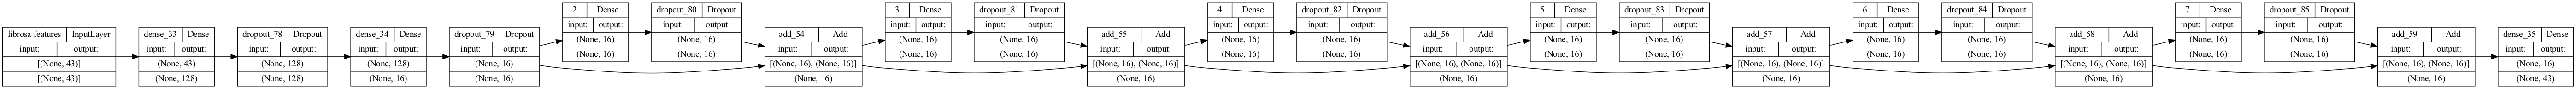

In [32]:
# architect model
num_labels = y.shape[1]
input_shape = X.shape[1]

# librosa features head
libosa_inputs = layers.Input(shape=input_shape, name='librosa features')
x = layers.Dense(128, activation='relu')(libosa_inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation='relu')(x)
block_1_output = layers.Dropout(0.5)(x)
# block 2
x = layers.Dense(16, activation='relu', name='2')(block_1_output)
x = layers.Dropout(0.5)(x)
block_2_output = layers.add([x, block_1_output])
# block 3
x = layers.Dense(16, activation='relu', name='3')(block_2_output)
x = layers.Dropout(0.5)(x)
block_3_output = layers.add([x, block_2_output])
# block 4
x = layers.Dense(16, activation='relu', name='4')(block_3_output)
x = layers.Dropout(0.5)(x)
block_4_output = layers.add([x, block_3_output])
# block 5
x = layers.Dense(16, activation='relu', name='5')(block_4_output)
x = layers.Dropout(0.5)(x)
block_5_output = layers.add([x, block_4_output])
# block 6
x = layers.Dense(16, activation='relu', name='6')(block_5_output)
x = layers.Dropout(0.5)(x)
block_6_output = layers.add([x, block_5_output])
# block 7
x = layers.Dense(16, activation='relu', name='7')(block_6_output)
x = layers.Dropout(0.5)(x)
block_7_output = layers.add([x, block_6_output])
# output block
output_block = layers.Dense(num_labels)(block_7_output)
# model definition
model = Model(inputs=[libosa_inputs], outputs=[output_block], name='functional')

# visualize model 
from keras.utils.all_utils import plot_model
plot_model(model, show_shapes=True, rankdir='LR', to_file='model.png', dpi=100)

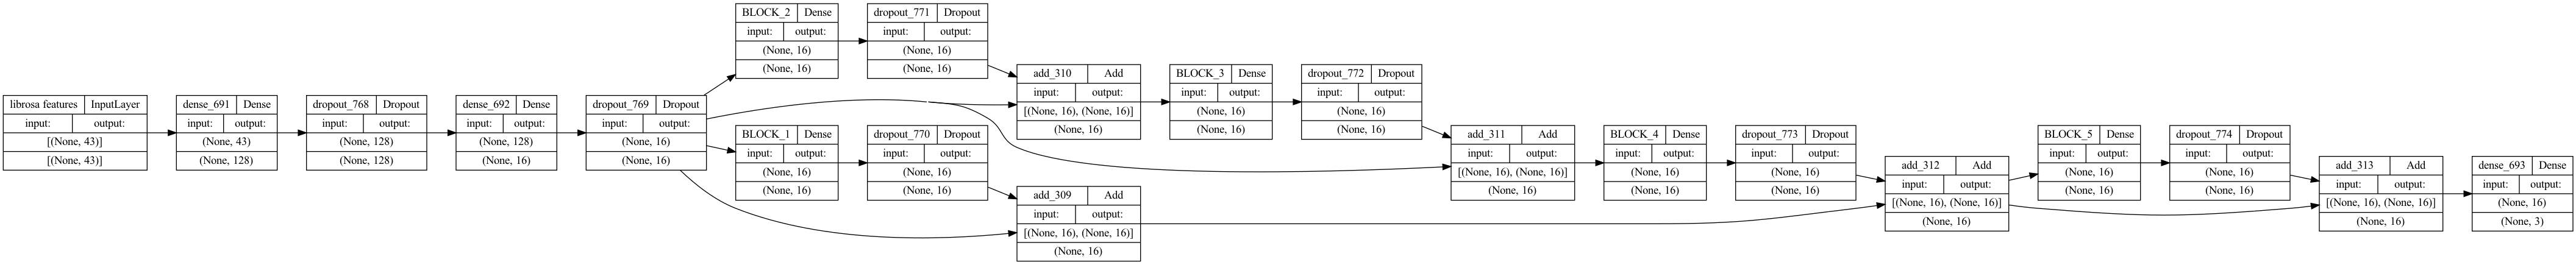

In [140]:
# # randomly generate model
# num_labels = y.shape[1]
# input_shape = X.shape[1]
# num_blocks = 5

# # librosa features head
# libosa_inputs = layers.Input(shape=input_shape, name='librosa features')
# x = layers.Dense(128, activation='relu')(libosa_inputs)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(16, activation='relu')(x)
# librosa_features_output = layers.Dropout(0.5)(x)

# blocks = {0:librosa_features_output}
# for n in range(1, num_blocks+1):
#     input_pick = np.random.randint(0, len(blocks))
#     output_pick = np.random.randint(0, len(blocks))
#     x = layers.Dense(16, activation='relu', name=f'BLOCK_{n}')(blocks[input_pick])
#     x = layers.Dropout(0.5)(x)
#     block_output = layers.add([x, blocks[output_pick]])
#     if n not in blocks:
#         blocks[n] = block_output

# # output block
# output_block = layers.Dense(num_labels)(block_output)
# # model definition
# model = Model(inputs=[libosa_inputs], outputs=[output_block], name='functional')

# # visualize model 
# from keras.utils.all_utils import plot_model
# plot_model(model, show_shapes=True, rankdir='LR')

In [33]:
# train the model
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
PARAMS = {
    'opt' : RMSProp(learning_rate=0.004), # 0.002:742, 0.003:612, 0.004:668, 0.006:605
    'loss' : 'mse',
    'bs' : 64,
    'epochs' : 200,
    'metrics' : ['accuracy']
}
model.compile(loss=PARAMS['loss'], metrics=PARAMS['metrics'], optimizer=PARAMS['opt'])

# model_checkpoint_callback = callbacks.ModelCheckpoint(
#     save_best_only=True, save_weights_only=False, 
#     filepath=CHECKPOINT_FILEPATH, monitor='val_loss', mode='auto')
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)

history = model.fit(
    x_train, y_train, batch_size=PARAMS['bs'], 
    epochs=PARAMS['epochs'], validation_data=(x_test, y_test), 
    verbose=1,) #callbacks=[reduce_lr_callback])

2022-05-06 12:21:58.678485: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200


2022-05-06 12:22:00.414259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.9244 - accuracy: 0.0912

2022-05-06 12:22:03.901767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 6s 89ms/step - loss: 0.9244 - accuracy: 0.0912 - val_loss: 0.0200 - val_accuracy: 0.9950
Epoch 2/200
13/13 [==============================] - 0s 22ms/step - loss: 0.0262 - accuracy: 0.5100 - val_loss: 0.0166 - val_accuracy: 0.9950
Epoch 3/200
13/13 [==============================] - 0s 22ms/step - loss: 0.0165 - accuracy: 0.8600 - val_loss: 0.0122 - val_accuracy: 0.9950
Epoch 4/200
13/13 [==============================] - 0s 21ms/step - loss: 0.0112 - accuracy: 0.9787 - val_loss: 0.0069 - val_accuracy: 0.9950
Epoch 5/200
13/13 [==============================] - 0s 21ms/step - loss: 0.0066 - accuracy: 0.9850 - val_loss: 0.0035 - val_accuracy: 0.9950
Epoch 6/200
13/13 [==============================] - 0s 23ms/step - loss: 0.0044 - accuracy: 0.9900 - val_loss: 0.0020 - val_accuracy: 0.9950
Epoch 7/200
13/13 [==============================] - 0s 21ms/step - loss: 0.0033 - accuracy: 0.9887 - val_loss: 0.0014 - val_accuracy: 0.9950
Epoch 8/200
13/13 

KeyboardInterrupt: 

2022-05-03 13:37:46.429823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Training Accuracy: 59.25%
Testing Accuracy: 59.00%
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


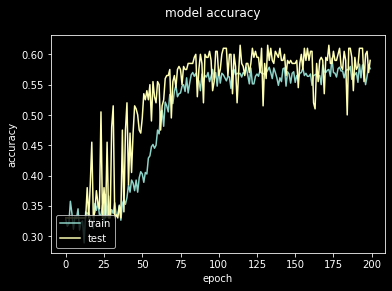

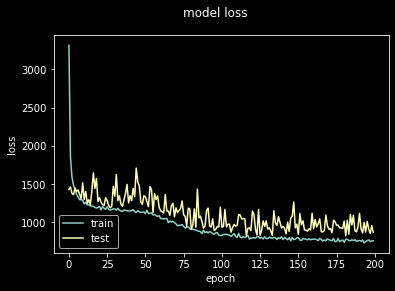

In [142]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

h_param_str = ''
for p in PARAMS:
    if p == 'opt' or 'metrics':
        continue
    h_param_str += (f'{p}:{PARAMS[p]} ')

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.suptitle('model accuracy')
plt.title(h_param_str)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.suptitle('model loss')
plt.title(h_param_str)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
# normalize datasets
train_data = normalize(train_data_raw)
test_data = normalize(test_data_raw)

NameError: name 'train_data_raw' is not defined

In [ ]:
# parse labels
train_labels = []
for l in train_labels_raw:
    train_labels.append([param_pair[1] for param_pair in eval(l)])
test_labels = []
for l in test_labels_raw:
    test_labels.append([param_pair[1] for param_pair in eval(l)])

In [ ]:
# reshape features & labels 
train_data = np.asarray(train_data)
test_data = np.asarray(test_data)
train_data = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [ ]:
# make, compile and fit the ML model
# input_shape must omit batch size, i.e. : [time steps, features]
# model = Sequential([
#         InputLayer(input_shape=train_data.shape[1:]),
#         # units = 8 is a value taken from https://arxiv.org/pdf/2009.02833.pdf
#         Conv1D(filters=32, kernel_size=1, activation='relu'), 
#         Conv1D(filters=32, kernel_size=1, activation='relu'),
#         MaxPooling1D(pool_size=1),
#         # Flatten(),
#         # Dense(10),
#         GRU(units=8, return_sequences=True), 
#         Dense(3)
#     ])
from tensorflow.python.keras.layers import Dropout
model = Sequential([
        InputLayer(input_shape=train_data.shape[1:]),
        # units = 8 is a value taken from https://arxiv.org/pdf/2009.02833.pdf
        Conv1D(filters=16, kernel_size=1, activation='relu'), 
        Conv1D(filters=16, kernel_size=1, activation='relu'),
        Dropout(0.8),
        MaxPooling1D(pool_size=1),
        GRU(units=128, return_sequences=True), 
        # Flatten(),
        # Dense(10),
        Conv1D(filters=32, kernel_size=1, activation='relu'), 
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        MaxPooling1D(pool_size=1),
        Dropout(0.8),
        GRU(units=128, return_sequences=True), 
        Dense(3)
    ])
from tensorflow.python.keras.optimizer_v2.adam import Adam
opt = Adam()
# model = make_model(input_shape=train_data.shape[1:])
model.compile(optimizer=opt,
              loss='mse',
              metrics=['accuracy'])
history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=20, batch_size=16, verbose=1)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-30 18:02:10.444199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-30 18:02:10.444386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-30 18:02:10.820904: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-04-30 18:02:12.845557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/50 [============================>.] - ETA: 0s - loss: 5172.3228 - accuracy: 0.0085

2022-04-30 18:02:15.816712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 5s 52ms/step - loss: 5152.8750 - accuracy: 0.0083 - val_loss: 4207.2075 - val_accuracy: 0.0100
Epoch 2/20
50/50 [==============================] - 2s 37ms/step - loss: 3918.0896 - accuracy: 0.0096 - val_loss: 3107.8218 - val_accuracy: 0.0100
Epoch 3/20
50/50 [==============================] - 2s 41ms/step - loss: 2990.7036 - accuracy: 0.0075 - val_loss: 2517.6982 - val_accuracy: 0.0100
Epoch 4/20
50/50 [==============================] - 2s 40ms/step - loss: 2473.6892 - accuracy: 0.0075 - val_loss: 2131.3167 - val_accuracy: 0.0100
Epoch 5/20
50/50 [==============================] - 2s 47ms/step - loss: 2128.8477 - accuracy: 0.0075 - val_loss: 1864.4349 - val_accuracy: 0.0100
Epoch 6/20
50/50 [==============================] - 2s 40ms/step - loss: 1889.6995 - accuracy: 0.0071 - val_loss: 1678.7473 - val_accuracy: 0.0100
Epoch 7/20
50/50 [==============================] - 2s 42ms/step - loss: 1721.2700 - accuracy: 0.0075 - val_loss: 1551.7260 - val

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


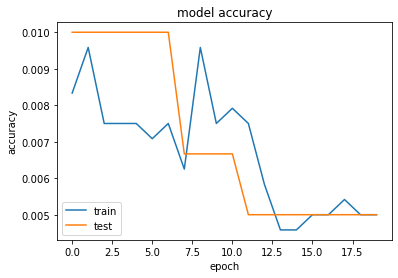

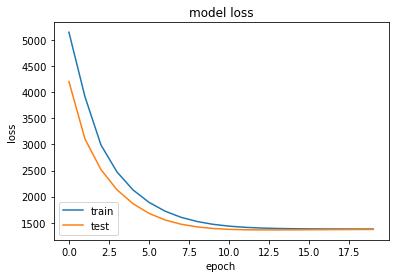

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()